### 一、通过在线学习的方法训练机器学习分类模型并且将其序列化后保存到本地

In [1]:
import pandas as pd 
'''
通过pandas.read_csv()导入的文件是经过数据清洗以及处理
以后保存到本地的电影评论数据以及标签。详情见上一篇笔记。
'''
df = pd.read_csv('./aclImdb_v1/movie_data.csv')
df.tail()

,review,sentiment
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0
49999,I waited long to watch this movie. Also becaus...,1


In [5]:
X_train = df.loc[:25000, 'review'].values
y_train = df.loc[:25000, 'sentiment'].values
X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

In [6]:
import numpy as np
import re
from nltk.corpus import stopwords

stop = stopwords.words('english')

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

# 定义一个生成器函数：stream_docs，它每次读取且返回一个文档的内容
def stream_docs(path):
    with open(file=path, mode='r', encoding='utf-8') as csv:
        next(csv) # skip header
        for line in csv: # 每一行都是字符串类型
            text, label = line[:-3],  int(line[-2]) # csv文件以换行结尾，故保存类标的下标应该是-2
            yield text, label
            
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

In [8]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
import pyprind

vect = HashingVectorizer(decode_error='ignore', n_features=2**21, preprocessor=None, tokenizer=tokenizer)
clf = SGDClassifier(loss='log', random_state=1, max_iter=1, tol=1e-3) # max_iter迭代的最大次数，tol控制在当前迭代得到的准确性能很小时，结束循环
doc_stream = stream_docs(path='./aclImdb_v1/movie_data.csv')


pbar = pyprind.ProgBar(45)
classes = np.array([0, 1])

for _ in range(45):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    pbar.update()   
    
print(pbar)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:31


Title: 
  Started: 07/11/2019 15:53:39
  Finished: 07/11/2019 15:54:10
  Total time elapsed: 00:00:31


In [9]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)
print('Accuracy: %.3f' % clf.score(X_test, y_test))
clf = clf.partial_fit(X_test, y_test) # 训练新数据，升级模型

Accuracy: 0.867


In [11]:
import pickle
import os

dest = os.path.join('movieclassifier', 'pkl_objects')
if not os.path.exists(dest): # 判断地址是否存在，如果不存在则创建一个新的
    os.makedirs(dest) 
'''
使用pickle中的dump方法，对训练好的逻辑斯谛回归模型及NLTK库中的停用词进行序列化，
dump方法的第一个参数是我们要持久化的对象，第二个参数用于制定序列化对象的保存路
径，在此我们使用了Python中的open方法。open方法中的wb参数代表以二进制方式存储数
据，而protocol=4则代表使用最新、最高效的protocol协议。
'''
pickle.dump(stop, open(os.path.join(dest, 'stopwords.pkl'), 'wb'), protocol=4)
pickle.dump(clf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)

注：以上代码展示了如何将一个训练好的机器学习模型通过pickle库序列化后保存到本地。而以下步骤则展示了如何将序列化后的机器学习模型嵌入到一个web应用中。

### 二、将序列化以后的机器学习模型嵌入到web应用中

<font color=red>**由于需要结合前端web开发的知识，故无法在Jupyter Notebook中展示全部过程。有兴趣的读者可以自己创建工程完成整个web应用的开发。**</font>

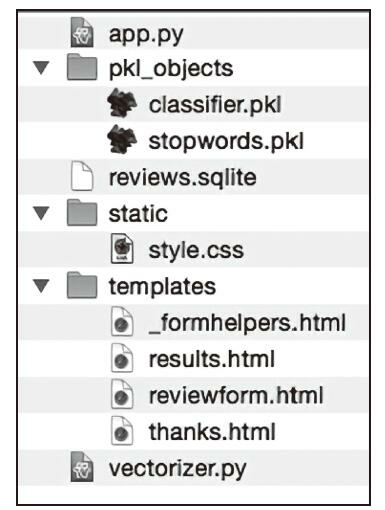

**上图是整个web应用的目录组织结构，读者应该创建一个工程文件夹，名字可以自定义，如MovieReviewClassifier，然后在此文件夹里按照上图所示的结构组织下述文件。**

### 1.app.py

In [ ]:
from flask import Flask, render_template, request
from wtforms import Form, TextAreaField, validators
from vectorizer import vect
from updata import updata_model
import pickle
import sqlite3
import os
import numpy as np

app = Flask(__name__)
# Preparing the Classifier
cur_dir = os.path.dirname(__file__)
clf = pickle.load(open(os.path.join(cur_dir, 'pkl_objects/classifier.pkl'), 'rb'))
db = os.path.join(cur_dir, 'reviews.sqlite')


def classify(document):
    label = {0: 'negative', 1: 'positive'}  # 类标字典
    X = vect.transform([document])
    y = clf.predict(X)[0]
    proba = np.max(clf.predict_proba(X))
    return label[y], proba


def train(document, y):
    X = vect.transform([document])
    clf.partial_fit(X, [y])


def sqlite_entry(path, document, y):
    conn = sqlite3.connect(path)
    c = conn.cursor()
    c.execute("INSERT INTO review_db (review, sentiment,data)"
              " VALUES (?, ?, DATETIME('now'))", (document, y))
    conn.commit()
    conn.close()


app = Flask(__name__)

class ReviewForm(Form):
    moviereview = TextAreaField('', [validators.DataRequired(), validators.length(min=15)])

@app.route('/')
def index():
    form = ReviewForm(request.form)
    return render_template('reviewform.html', form=form)

@app.route('/results', methods=['POST'])
def results():
    form = ReviewForm(request.form)
    if request.method == 'POST' and form.validate():
        review = request.form['moviereview']
        y, proba = classify(review)  # 返回标签和概率
        return render_template('results.html', content=review, prediction=y, probability=round(proba * 100, 2))
    return render_template('reviewform.html', form=form)

@app.route('/thanks', methods=['POST'])
def feedback():
    feedback = request.form['feedback_button']
    review = request.form['review']
    prediction = request.form['prediction']
    inv_label = {'negative': 0, 'positive': 1}
    y = inv_label[prediction]
    if feedback == 'Incorrect':
        y = int(not(y))
    train(review, y)
    sqlite_entry(db, review, y)
    return render_template('thanks.html')

if __name__ == '__main__':
    updata_model(db_path=db, model=clf, batch_size=10000)
    app.run()

### 2.vertorizer.py

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer
import re 
import os
import pickle

cur_dir = os.path.dirname(__file__)
stop = pickle.load(open(os.path.join(cur_dir, 'pkl_objects', 'stopwords.pkl'), 'rb'))

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

vect = HashingVectorizer(decode_error='ignore', n_features=2**21, preprocessor=None, tokenizer=tokenizer)

### 3.pkl_objects目录下的文件是上述代码产生的序列化文件

### 4.style.css

In [ ]:
body{
	width: 600px;
}
#button{
	padding-top: 20px;
}

### 5._formhelpers.html

In [ ]:
{% macro render_field(field) %}
	<dt>{{ field.label }}
	<dd>{{ field(**kwargs)|safe }}
	{% if field.errors %}

		<ul class=errors>
		{% for error in field.errors %}
			<li>{{ error }}</li>
		{% endfor %}
		</ul>
	{% endif %}
	</dd>
{% endmacro %}

### 6.results.html

In [ ]:
<!DOCTYPE html>
<html>
	<head>
		<title>Movie Classification</title>
	<link rel="stylesheet" href="{{ url_for('static', filename='style.css') }}" >
	</head>

<body>
<h3>Your movie review:</h3>
<div>{{ content }}</div>
<h3>Prediction:</h3>

<div>This movie review is <strong>{{ prediction }}</strong>(probability: {{ probability }}%).</div>
<div id='button'>
	<form action="/thanks" method="post">
		<input type=submit value="Correct" name='feedback_button'>
		<input type=submit value="Incorrect" name='feedback_button'>	
		<input type=hidden value="{{ prediction }}" name='prediction'>
		<input type=hidden value="{{ content }}" name='review'>
	</form>
</div>

<div id="button">
	<form action="/">
		<input type=submit value="submit another review">
	</form>
</div>
</body>
</html>

### 7.reviewform.html

In [ ]:
<!DOCTYPE html>
<html>
	<head>
		<title>Movie Classification</title>
	</head>
<body>

<h2>Please enter your movie review:</h2>

{% from "_formhelpers.html" import render_field %}

<form method=post action="/results">
	<dl>
		{{ render_field(form.moviereview, cols='30', rows='10') }}
	</dl>


	<div> 	
		<input type=submit value="submit review" name="submit_btn">
	</div>

</form>
</body>
</html>

### 8.thanks.html

In [ ]:
<!DOCTYPE html>
<html>
	<head>
		<title>Movie Classification</title>
	</head>
<body>

<h2>Please enter your movie review:</h2>

{% from "_formhelpers.html" import render_field %}

<form method=post action="/results">
	<dl>
		{{ render_field(form.moviereview, cols='30', rows='10') }}
	</dl>


	<div> 	
		<input type=submit value="submit review" name="submit_btn">
	</div>

</form>
</body>
</html>

完成上述操作后，读者可以打开系统的dos界面，运行应用的主脚本文件app.py。windows用户在dos界面定位到工程的主目录后，输入以下命令：python app.py。即可在本地检验web应用是否能够顺利运行。如果程序运行顺利，则可进入下一步，将web应用部署到公共服务器上。

<font color=red>本文将使用PythonAnywhere托管Web服务。步骤如下：</font>

1.创建一个新的PythonAnywhere账户。需要访问<https://www.pythonanywhere.com>，并点击右上角的“Pricing&signup”链接。

2.在PythonAnywhere账户中创建一个新的Web应用。点击右上角的“Dashboard”按钮，就可以看到页面顶部显示的控制面板。接下来，点击页面顶部的“Web”标签，然后点击左侧的“Add a new Web app”按钮创建一个新的基于你所用版本的Python的Flask Web应用，并将其命名为MovieReviewClassifier(可以自定义)。

3.点击菜单栏的“Files”链接，进入MovieReviewClassifier目录下，通过“Upload a file”上传文件，要求文件的目录结构跟本地工程的一致。

4.上传完毕后，点击菜单栏的“Web”链接，然后点击“Reload (用户名).pythonanywhere.com”即可在指定网址访问你的Web应用。注意：app.py文件上传到PythonAnywhere后需要改成flask_app.py，不然会报错。在本地文件夹保留app.py是可以成功运行的，但是托管到PythonAnywhere需要改成flask_app.py，可能是服务器默认将此文件当作Web应用启动的主脚本文件。

**以下代码展示了如何更新你的电影评论分类器：**

在工程的主目录下创建一个update.py文件，键入以下代码：

In [ ]:
import pickle
import sqlite3
import numpy as np
import os

# import HasingVectorizer from local dir
from vectorizer import vect


def updata_model(db_path, model, batch_size=10000):
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute('SELECT * from review_db')

    results = c.fetchmany(batch_size)
    while results:
        data = np.array(results)
        X = data[:, 0]
        y = data[:, 1].astype(int)

        classes = np.array([0, 1])
        X_train = vect.transform(X)
        clf.partial_fit(X_train, y, classes=classes)
        results = c.fetchmany(batch_size)
    conn.close()
    return None


cur_dir = os.path.dirname(__file__)
clf = pickle.load(open(os.path.join(cur_dir, 'pkl_objects', 'classifier.pkl'), 'rb'))
db = os.path.join(cur_dir, 'reviews.sqlite')

updata_model(db_path=db, model=clf, batch_size=10000)

# Uncomment the following lines if you are sure that
# you want to updata your classifier.pkl file permanently

# pickle.dump(clf, open(os.path.join(cur_dir, 'pkl_objects', 'classifier.pkl'), 'wb'), protocol=4)


在app.py(flash_app.py)文件中添加以下几行代码：

In [ ]:
from update import update_model

...

if __name__ == '__name__':
    update_model(db_path=db, model=clf, batch_size=10000)
...

总结：至此，如何将机器学习模型序列化以及如何将其嵌入到Web应用的学习已经结束了，在以后，如果有需要开发使用机器学习算法的Web应用的读者，可以参考和借鉴本文的实现过程。